# Image registration

In some cases a calibration image of a field containing a lot of stars obtained with SITELLE in the same filter and during the same run as the science data can be used to compute a distortion model that can be then used directly to enhance the astrometrical calibration of the science cube which may have much less stars. The distortion model is then kept as is and only the basic registration parameters are recomputed (see Martin el al. 2017, http://adsabs.harvard.edu/abs/2017arXiv170701366M)

In [2]:
import pylab as pl
import orb.image
import logging
# useful to get logging output. orb and orcs use the logging package which is automatically set to INFO level when a cube is loaded.
# But, as we are not loading a cube this time and only working on images, you must do it manually.
logging.getLogger().setLevel(logging.INFO) 

## Initial calibration
`target_ra` and `target_dec` are the celestial coordinates at the center of the image.

**note: this process can be done in two steps. For the first step we are only concerned with the calibration of the center of the image. During the second step a distortion model is computed over the whole field of view**. 

In [ ]:
im = orb.image.Image('M1-71_SN3.merged.InterferogramMerger.deep_frame.fits', instrument='sitelle')
# in case any wrong wcs parameters were stored in the header, it is safe to reset the wcs to get a fresh start before the registration.
im.reset_wcs(294.1120729, 19.70678597) 
im.register()

In [4]:
# the HDF5 format is the native format for orb and orcs and you are sure to keep all the data with it. 
# But for an image you can, in principle, safely use the fits format.
im.writeto('M1-71.deep_frame.wcs.init.hdf5') 
im.to_fits('M1-71.deep_frame.wcs.init.fits')

INFO:root:Data written as M1-71.deep_frame.wcs.init.fits in 0.05 s 


In [2]:
# now we will check the results of the calibration by loading the positions of the stars in the field from the gaia catalog 
# before plotting them on the image
im = orb.image.Image('M1-71.deep_frame.wcs.init.hdf5')
sl = im.get_stars_from_catalog(max_stars=1000)

INFO:root:Sending query to VizieR server (catalog: gaia2)
INFO:root:Looking for stars at RA: 294.113293 DEC: 19.706693
INFO:root:1000 stars recorded in the given field
INFO:root:Magnitude min: 9.5522, max:17.1995


In [4]:
sl # the catalog position ra, dec as well as their positions in pixels are stroed in a pandas.DataFrame object

x            y          ra        dec
0    1264.454377   286.145713  294.091757  19.639255
1    1724.392602  1250.186154  294.045982  19.725027
2     419.186355  1268.322106  294.170612  19.728998
3     902.256353  1206.209789  294.124590  19.722561
4    1696.768721   562.242566  294.049953  19.663274
..           ...          ...         ...        ...
654  1471.934583  2031.989426  294.068588  19.795722
655  1948.153033  1610.327001  294.023907  19.756971
656  1561.509786  1794.601911  294.060488  19.774233
657  2003.091878  1433.274841  294.019005  19.740964
658  1237.617490  1228.616455  294.092516  19.723973

[659 rows x 4 columns]

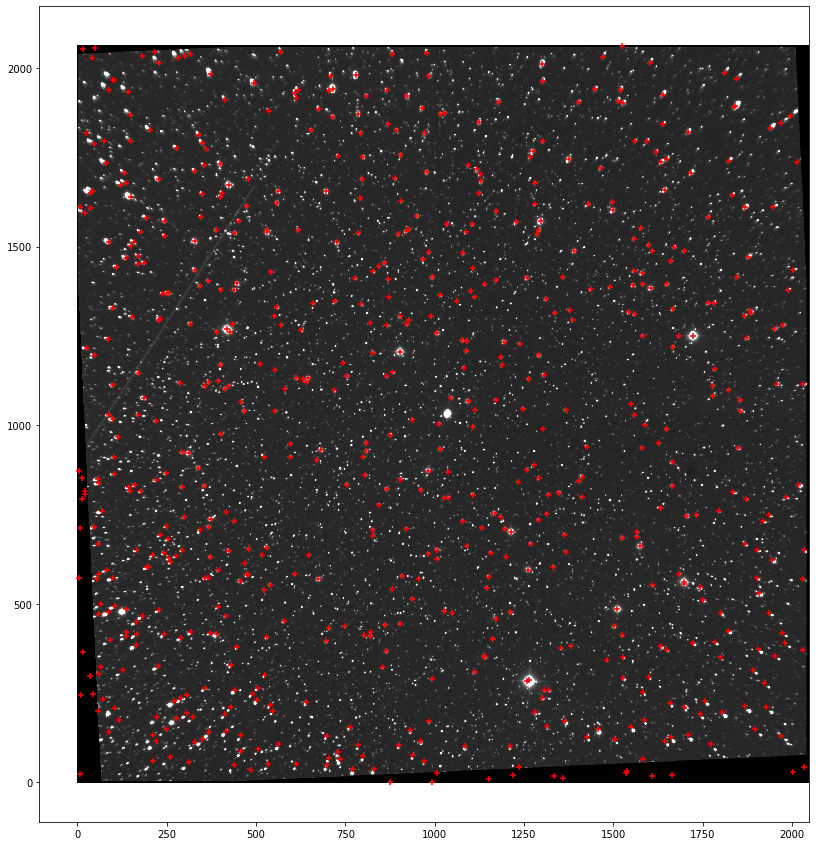

In [5]:
# You can see that the registration is correct near the center of the field but without a proper distortion model, the position in the corners can be very bad.
im.imshow(cmap='gray', wcs=False)
pl.scatter(sl.x, sl.y, marker='+', color='red')

## Final calibration

The obtained wcs is used as an input for the final calibration. Now the whole field of view can be considered.

A few passes may be necessary to get a good enough astrometrical precision in the corners. But don't try to get something perfect here (above all with cubes obtained before the optical upgrade of 2020 - http://www.cfht.hawaii.edu/en/news/SITELLEUpgrade/), the distortion is very important and capturing the stars in the corners may worsen the astrometrical precision in the center.

In [53]:
im = orb.image.Image('M1-71.deep_frame.wcs.init.hdf5')
wcs, dxmap, dymap = im.register(skip_registration=True, compute_distortion=True, return_error_maps=True, max_radius_coeff=2, sip_order=4, max_stars_detect=200)
im.writeto('M1-71.deep_frame.wcs.sip1.hdf5')

INFO:root:Computing WCS
INFO:root:initial wcs
INFO:root:WCS Transformation

This transformation has 2 pixel and 2 world dimensions

Array shape (Numpy order): (2064, 2048)

Pixel Dim  Data size  Bounds
        0       2048  None
        1       2064  None

World Dim  Physical Type  Units
        0  pos.eq.ra      deg
        1  pos.eq.dec     deg

Correlation between pixel and world axes:

           Pixel Dim
World Dim    0    1
        0  yes  yes
        1  yes  yes
INFO:root:initial sip: None
INFO:root:Sending query to VizieR server (catalog: gaia2)
INFO:root:Looking for stars at RA: 294.113293 DEC: 19.706693
INFO:root:14059 stars recorded in the given field
INFO:root:Magnitude min: 9.5522, max:21.0
INFO:root:5753 stars detected
INFO:root:star list reduced to 200 stars
INFO:root:Detected stars FWHM : 3.22(0.11) pixels, 1.04(0.04) arc-seconds
INFO:root:Computing SIP coefficients
INFO:root:sip before sip fit (A matrix)
INFO:root:no sip
INFO:root:sip computed with 4000 stars
INFO:root

## Check the results

INFO:root:Sending query to VizieR server (catalog: gaia2)
INFO:root:Looking for stars at RA: 294.113336 DEC: 19.706637
INFO:root:1000 stars recorded in the given field
INFO:root:Magnitude min: 9.5522, max:17.1968


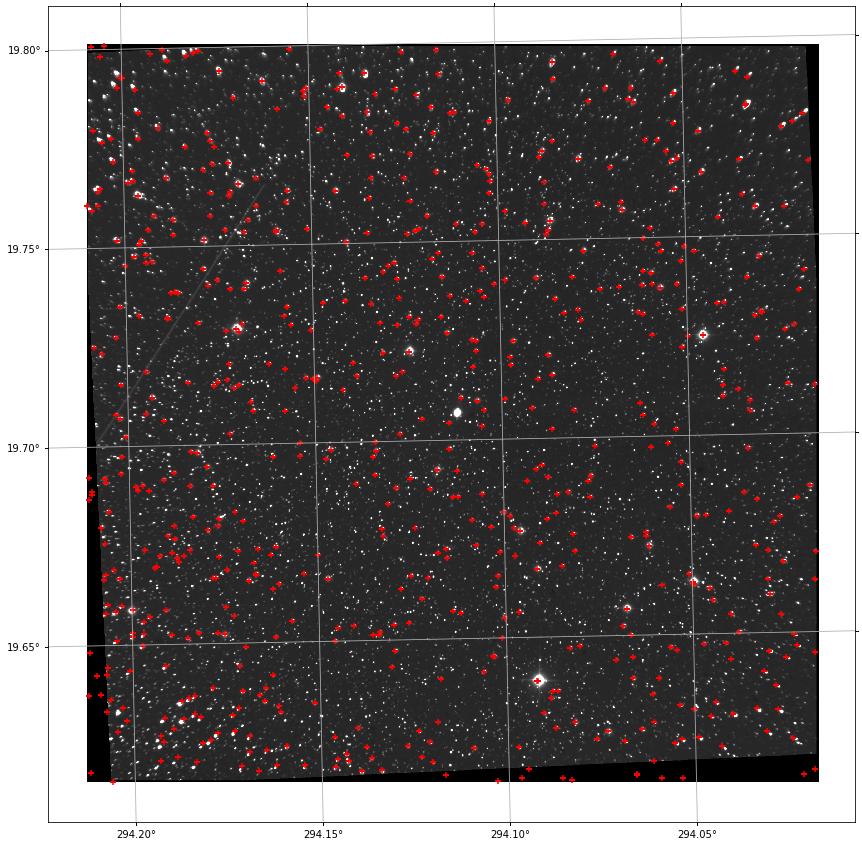

In [55]:
im = orb.image.Image('M1-71.deep_frame.wcs.sip1.hdf5')
sl = im.get_stars_from_catalog(max_stars=1000)
im.imshow(cmap='gray', wcs=True)
pl.scatter(sl.x, sl.y, marker='+', color='red')
pl.grid()